### CUDA Exploration Notebook

In [1]:
## Verify Installation
print("Verify the installation by running `nvcc --version` in the terminal or command prompt.")
!nvcc --version

Verify the installation by running `nvcc --version` in the terminal or command prompt.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


#### Imports

In [2]:
import numpy as np
from numba import cuda, float32
import matplotlib.pyplot as plt
from matplotlib.image import imread

#### Basic CUDA Programming

In [3]:
# Define the CUDA kernel
@cuda.jit
def vector_add(a, b, c):
    idx = cuda.grid(1)
    if idx < a.size:
        c[idx] = a[idx] + b[idx]

# Initialize data for vector addition
N = 1000000
a = np.ones(N, dtype=np.float32)
b = np.ones(N, dtype=np.float32)
c = np.zeros(N, dtype=np.float32)

# Allocate device memory
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.to_device(c)

# Launch the kernel
threads_per_block = 256
blocks_per_grid = (a.size + (threads_per_block - 1)) // threads_per_block
vector_add[blocks_per_grid, threads_per_block](a_device, b_device, c_device)

# Copy the result back to the host
c_device.copy_to_host(c)

print("Vector addition result (first 10 elements):")
print(c[:10])  # Expected output: [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]

Vector addition result (first 10 elements):
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


#### Matrix Multiplication using CUDA

In [4]:
# Define the CUDA kernel for matrix multiplication
@cuda.jit
def matrix_multiply(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        temp = 0
        for k in range(A.shape[1]):
            temp += A[row, k] * B[k, col]
        C[row, col] = temp

# Initialize data for matrix multiplication
N = 1024  # Adjust size for complexity
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)
C = np.zeros((N, N), dtype=np.float32)

# Allocate device memory
A_device = cuda.to_device(A)
B_device = cuda.to_device(B)
C_device = cuda.to_device(C)

# Launch the kernel
threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(A.shape[0] / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(B.shape[1] / threads_per_block[1]))
matrix_multiply[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](A_device, B_device, C_device)

# Copy the result back to the host
C_device.copy_to_host(C)

print("Matrix multiplication result (first 2x2 elements):")
print(C[:2, :2])

Matrix multiplication result (first 2x2 elements):
[[253.49265 257.549  ]
 [264.69553 267.61502]]


#### CNN Forward Pass

In [5]:
# Load a real image
image_path = 'images/image2.jpg'  # Update this with the path to your image
image = imread(image_path)

# Ensure the image array is contiguous
image = np.ascontiguousarray(image)

In [6]:
# Define the CUDA kernel for convolution
@cuda.jit
def conv2d(input, kernel, output):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    # Compute global thread coordinates
    row = by * cuda.blockDim.y + ty
    col = bx * cuda.blockDim.x + tx

    if row < input.shape[0] and col < input.shape[1]:
        # Apply convolution only within valid range
        if row > 0 and row < input.shape[0] - 1 and col > 0 and col < input.shape[1] - 1:
            value = 0.0
            for i in range(3):
                for j in range(3):
                    value += input[row + i - 1, col + j - 1] * kernel[i, j]
            output[row - 1, col - 1] = value

In [7]:
# Sobel Kernels
sobel_horizontal = np.array([[ 1,  2,  1],
                             [ 0,  0,  0],
                             [-1, -2, -1]], dtype=np.float32)

sobel_vertical = np.array([[ 1,  0, -1],
                           [ 2,  0, -2],
                           [ 1,  0, -1]], dtype=np.float32)



In [8]:
# Function to apply convolution on each color channel
def apply_convolution(input_image, kernel):
    output_feature_map = np.zeros((input_image.shape[0] - 2, input_image.shape[1] - 2, input_image.shape[2]), dtype=np.float32)
    
    # Allocate device memory for the kernel
    kernel_device = cuda.to_device(kernel)
    
    for channel in range(input_image.shape[2]):
        # Ensure each channel is contiguous
        input_channel = np.ascontiguousarray(input_image[:, :, channel])
        
        # Allocate device memory for the input and output
        input_device = cuda.to_device(input_channel)
        output_channel = np.zeros((input_image.shape[0] - 2, input_image.shape[1] - 2), dtype=np.float32)
        output_device = cuda.to_device(output_channel)
        
        # Launch the kernel
        threads_per_block = (16, 16)
        blocks_per_grid_x = (input_image.shape[1] + threads_per_block[0] - 1) // threads_per_block[0]
        blocks_per_grid_y = (input_image.shape[0] + threads_per_block[1] - 1) // threads_per_block[1]
        conv2d[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](input_device, kernel_device, output_device)
        
        # Copy the result back to the host
        output_device.copy_to_host(output_channel)
        output_feature_map[:, :, channel] = output_channel
    
    return output_feature_map

In [9]:
# Apply the Sobel filters to each color channel
output_feature_map_horizontal = apply_convolution(image, sobel_horizontal)
output_feature_map_vertical = apply_convolution(image, sobel_vertical)

# Compute the magnitude of gradients
output_feature_map = np.sqrt(output_feature_map_horizontal**2 + output_feature_map_vertical**2)

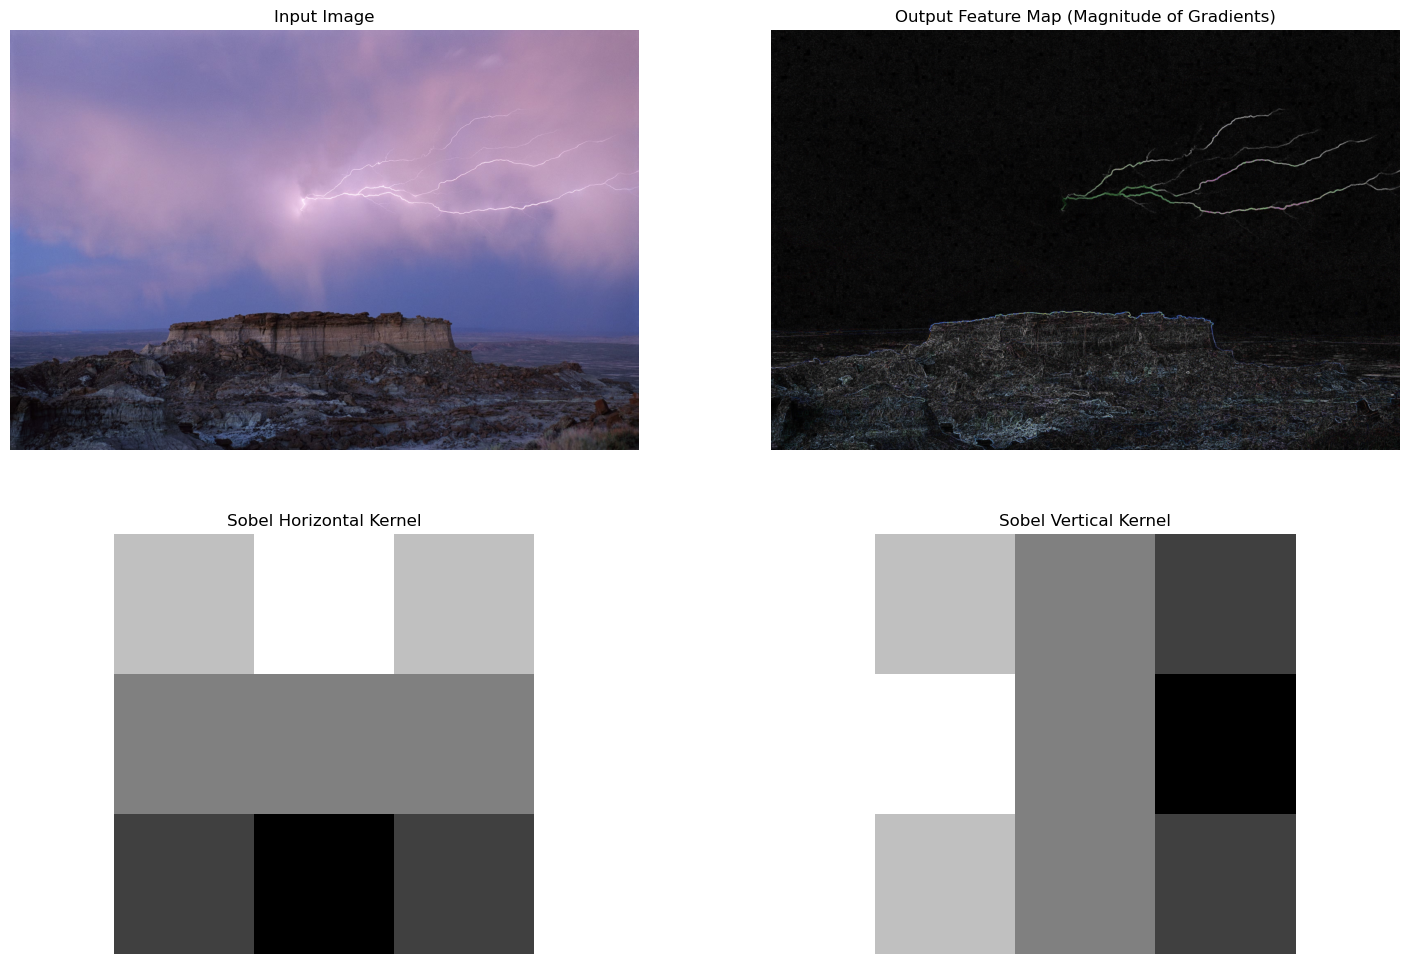

In [10]:
# Visualization
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

ax[0, 0].imshow(image)
ax[0, 0].set_title('Input Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(output_feature_map.astype(np.uint8))
ax[0, 1].set_title('Output Feature Map (Magnitude of Gradients)')
ax[0, 1].axis('off')

ax[1, 0].imshow(sobel_horizontal, cmap='gray')
ax[1, 0].set_title('Sobel Horizontal Kernel')
ax[1, 0].axis('off')

ax[1, 1].imshow(sobel_vertical, cmap='gray')
ax[1, 1].set_title('Sobel Vertical Kernel')
ax[1, 1].axis('off')

plt.show()

In [11]:
print("Convolution result (first 5x5 elements of each channel):")
for channel in range(3):
    print(f"Channel {channel}:")
    print(output_feature_map[:5, :5, channel])

Convolution result (first 5x5 elements of each channel):
Channel 0:
[[47.434166  28.84441   26.305893  27.784887  16.124516 ]
 [16.124516  13.341664  22.090721  16.552946   8.602325 ]
 [ 3.1622777  5.8309517  1.4142135  1.4142135  7.2111025]
 [ 9.486833   2.         9.486833  11.401754  12.806249 ]
 [ 7.071068   9.899495  10.29563    3.1622777 14.142136 ]]
Channel 1:
[[47.434166  28.84441   26.305893  27.784887  16.124516 ]
 [16.124516  13.341664  22.090721  16.552946   8.602325 ]
 [ 3.1622777  5.8309517  1.4142135  1.4142135  7.2111025]
 [ 9.486833   2.         9.486833  11.401754  12.806249 ]
 [ 7.071068   9.899495  10.29563    3.1622777 14.142136 ]]
Channel 2:
[[47.434166  28.84441   26.305893  27.784887  16.124516 ]
 [16.124516  13.341664  22.090721  16.552946   8.602325 ]
 [ 3.1622777  5.8309517  1.4142135  1.4142135  7.2111025]
 [ 9.486833   2.         9.486833  11.401754  12.806249 ]
 [ 7.071068   9.899495  10.29563    3.1622777 14.142136 ]]


### Monte Carlo Simulation for Option Pricing

In [18]:
# Parameters
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1     # Time to maturity in years
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
num_simulations = 1000000

#### CPU Implementation

In [19]:
import numpy as np
import time

def monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations):
    np.random.seed(0)
    payoff_sum = 0

    for _ in range(num_simulations):
        ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.normal())
        payoff = max(ST - K, 0)
        payoff_sum += payoff

    option_price = np.exp(-r * T) * payoff_sum / num_simulations
    return option_price

# Calculate option price using CPU
start_time = time.time()
option_price_cpu = monte_carlo_option_pricing(S0, K, T, r, sigma, num_simulations)
cpu_time = time.time() - start_time
print(f"Option Price (CPU): {option_price_cpu:.2f}")
print(f"CPU Time: {cpu_time:.4f} seconds")

Option Price (CPU): 10.47
CPU Time: 2.0361 seconds


#### GPU Implementation withCUDA

In [20]:
import numpy as np
import time
from numba import cuda, float32
import math

@cuda.jit
def monte_carlo_kernel(S0, K, T, r, sigma, num_simulations, rand_normals, d_payoffs):
    idx = cuda.grid(1)
    if idx < num_simulations:
        # Get the pre-generated random number
        normal_random = rand_normals[idx]
        ST = S0 * math.exp((r - 0.5 * sigma ** 2) * T + sigma * math.sqrt(T) * normal_random)
        payoff = max(ST - K, 0)
        d_payoffs[idx] = payoff

def monte_carlo_option_pricing_gpu(S0, K, T, r, sigma, num_simulations):
    threads_per_block = 256
    blocks_per_grid = (num_simulations + threads_per_block - 1) // threads_per_block

    # Pre-generate random numbers on the host
    rand_normals = np.random.normal(size=num_simulations).astype(np.float32)
    
    # Allocate device memory
    d_rand_normals = cuda.to_device(rand_normals)
    d_payoffs = cuda.device_array(num_simulations, dtype=np.float32)
    
    # Launch the kernel
    monte_carlo_kernel[blocks_per_grid, threads_per_block](S0, K, T, r, sigma, num_simulations, d_rand_normals, d_payoffs)
    
    # Copy the results back to the host
    payoffs = d_payoffs.copy_to_host()
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# Calculate option price using GPU
start_time = time.time()
option_price_gpu = monte_carlo_option_pricing_gpu(S0, K, T, r, sigma, num_simulations)
gpu_time = time.time() - start_time
print(f"Option Price (GPU): {option_price_gpu:.2f}")
print(f"GPU Time: {gpu_time:.4f} seconds")

Option Price (GPU): 10.45
GPU Time: 0.0739 seconds


#### Performance Comparison

In [21]:
# Performance comparison
print(f"CPU Time: {cpu_time:.4f} seconds")
print(f"GPU Time: {gpu_time:.4f} seconds")
speedup = cpu_time / gpu_time
print(f"Speedup: {speedup:.2f}x")

CPU Time: 2.0361 seconds
GPU Time: 0.0739 seconds
Speedup: 27.56x


#### Visualizations

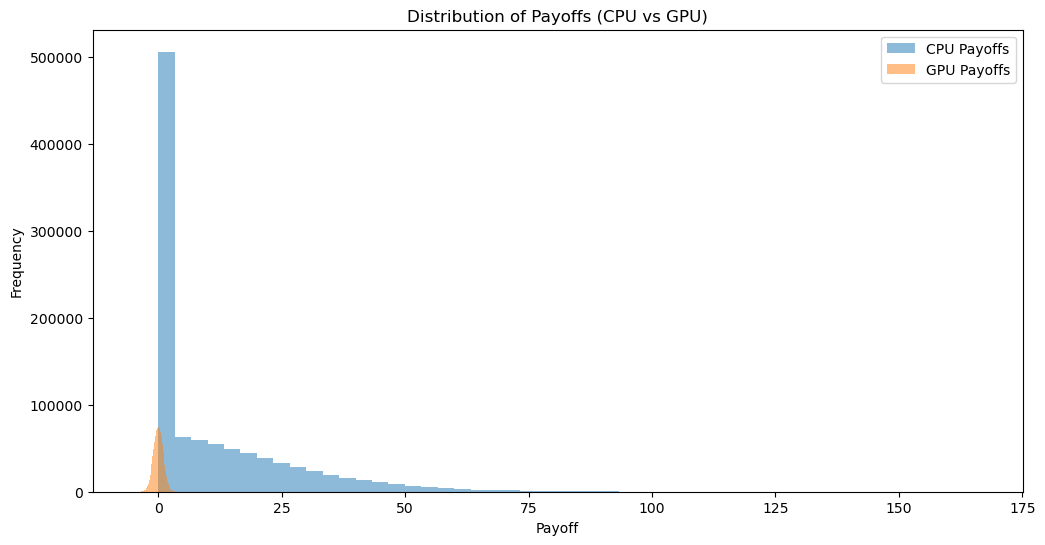

In [22]:
# Plot the distribution of payoffs
payoffs_cpu = [S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.normal()) - K for _ in range(num_simulations)]
payoffs_cpu = [max(payoff, 0) for payoff in payoffs_cpu]

payoffs_gpu = np.random.normal(size=num_simulations).astype(np.float32)  # Ensure the same number of payoffs for plotting

plt.figure(figsize=(12, 6))
plt.hist(payoffs_cpu, bins=50, alpha=0.5, label='CPU Payoffs')
plt.hist(payoffs_gpu, bins=50, alpha=0.5, label='GPU Payoffs')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Payoffs (CPU vs GPU)')
plt.show()

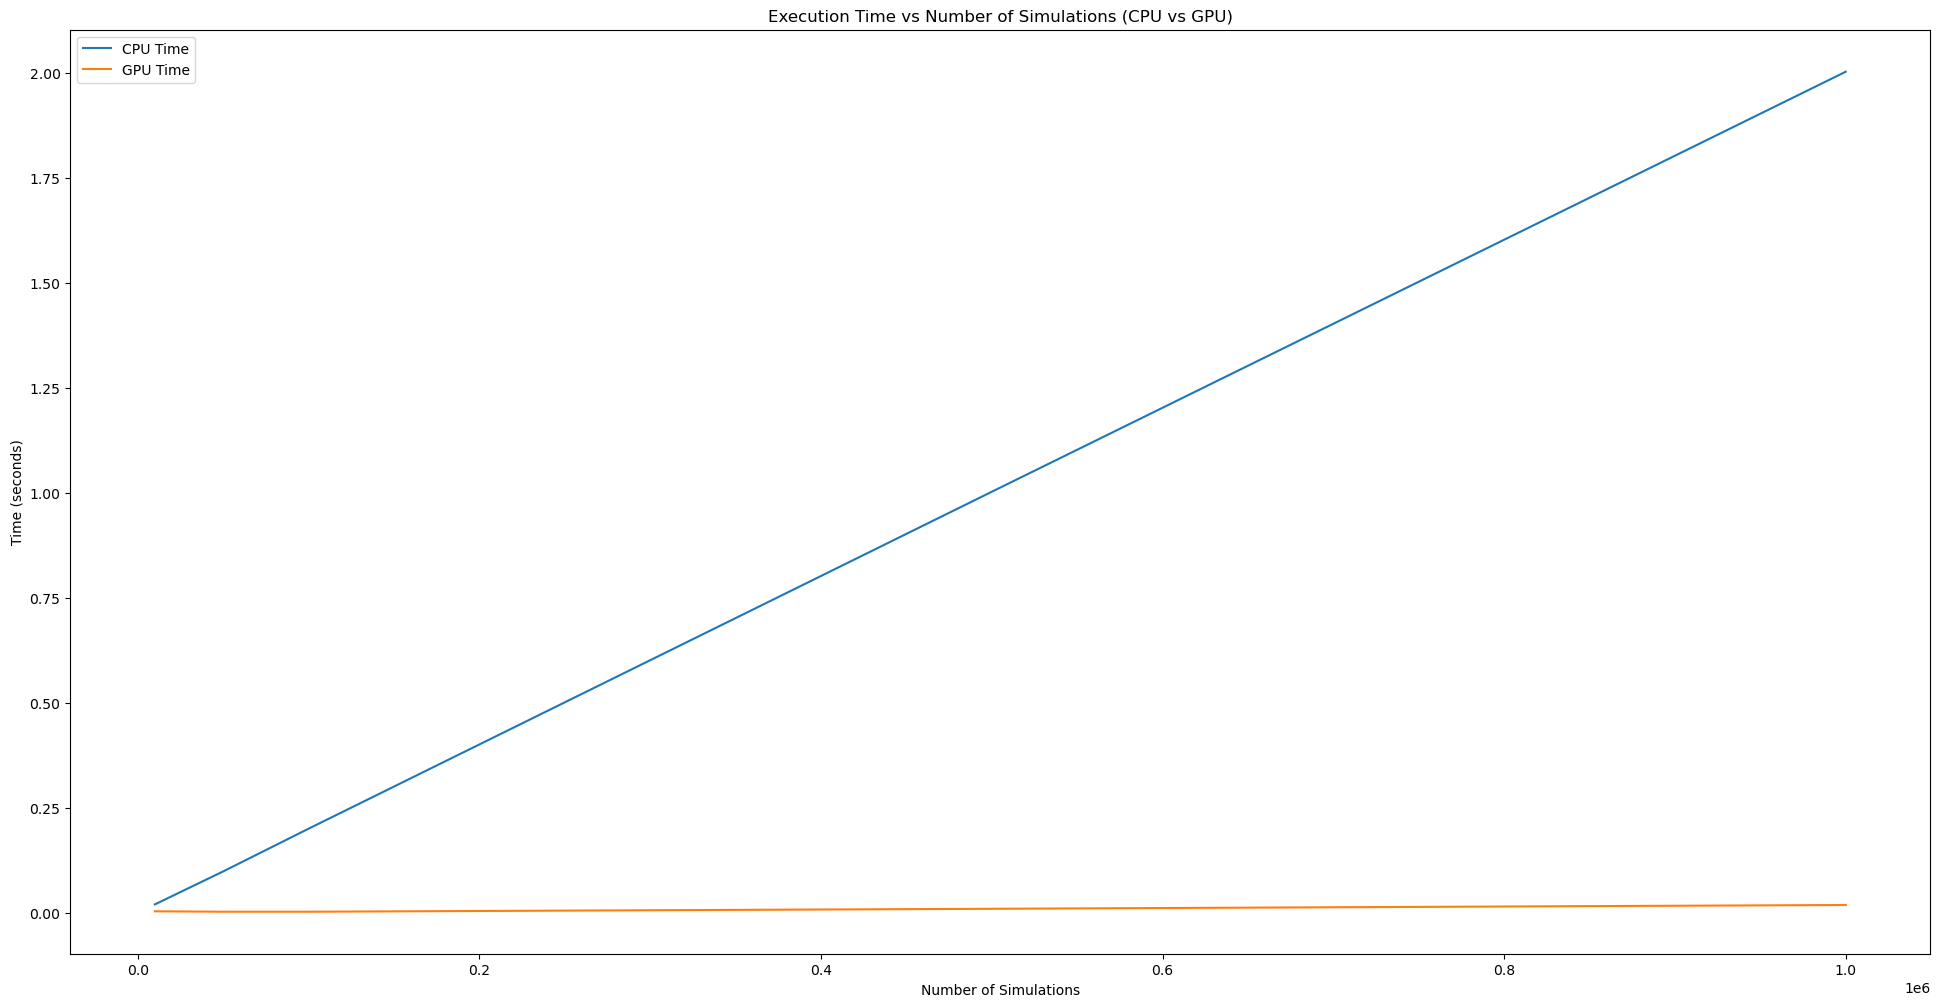

In [25]:
# Execution time for different numbers of simulations
simulation_counts = [10000, 50000, 100000, 500000, 1000000]
cpu_times = []
gpu_times = []

for num_sim in simulation_counts:
    # CPU time
    start_time = time.time()
    monte_carlo_option_pricing(S0, K, T, r, sigma, num_sim)
    cpu_times.append(time.time() - start_time)
    
    # GPU time
    start_time = time.time()
    monte_carlo_option_pricing_gpu(S0, K, T, r, sigma, num_sim)
    gpu_times.append(time.time() - start_time)

plt.figure(figsize=(24, 12))
plt.plot(simulation_counts, cpu_times, label='CPU Time')
plt.plot(simulation_counts, gpu_times, label='GPU Time')
plt.xlabel('Number of Simulations')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Execution Time vs Number of Simulations (CPU vs GPU)')
plt.show()